# Hamiltonian Learning

Implementation of "Learning many-body Hamiltonians with Heisenberg-limited scaling" by Huang et al. https://arxiv.org/pdf/2210.03030.pdf

In [3]:
import numpy as np
import qutip as qt
import math
import scipy
import matplotlib.pyplot as plt
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import (
    Gate, controlled_gate, hadamard_transform)

## Single-qubit Hamiltonian

Suppose we want to learn the parameters of the single-qubit unknown Hamiltonian $$H = \lambda_x X + \lambda_y Y + \lambda_z Z$$ where $|\lambda_x|, |\lambda_y|, |\lambda_z| \leq 1$ and $X, Y, Z$ are the Pauli operators. <br> 

First, we generate a Hamiltonian we want to learn, namely $H = 0.2 X + 0.5 Y + 0.6Z$. 

In [4]:
px, py, pz = [-0.2, 0.5, 0.6]
H = px * qt.sigmax() + py * qt.sigmay() + pz * qt.sigmaz()
H

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.6+0.j  -0.2-0.5j]
 [-0.2+0.5j -0.6+0.j ]]

### Reshape

The traditional approach is let a known state evolve under the application of the unitary $e^{-iHt}$ but the linear combination of Pauli operators restricts us from doing so. So instead, we can "reshape" $H$ by taking advantage of the commutator relationships. Suppose we want to learn $\lambda_x$, then we can isolate $X$ through the following application of operators: $$\tilde{H} = \frac{1}{2}IHI + \frac{1}{2}XHX = \lambda_xX$$

In [5]:
w1 = 1/2
w2 = 1/2
U1 = qt.qeye(2)
U2 = qt.sigmax()

H_tilde = w1*U1*H*U1 + w2*U2*H*U2
H_tilde

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.  -0.2]
 [-0.2  0. ]]

### Robust Phase Estimation

In order to learn the parameters $\lambda$ according to the Heisenberg limit $\mathcal{O}(\epsilon^{-1})$, Huang et al. utilizes robust phase estimation (RPE). The details can be found in Kimmel et al. https://arxiv.org/pdf/1502.02677.pdf 

The following implementation was largely based on the RobustPhaseEstimation method contained in Microsoft's Quantum Libraries located at https://github.com/microsoft/QuantumLibraries/blob/f2f5e380225367ee4eb995d922067025dc77f0a0/Standard/src/Characterization/PhaseEstimation/Robust.qs#L31
 <br> But modifications were made in regards to how the estimate of parameter $\lambda$ is converged upon, choice of $|0\rangle$- and $|+\rangle$-experiments, and various metrics to analyze the performance of the algorithm. 

**Other References:**
- https://github.com/microsoft/QuantumLibraries/blob/f2f5e380225367ee4eb995d922067025dc77f0a0/Standard/src/Characterization/PhaseEstimation/Iterative.qs 
- https://qutip-qip.readthedocs.io/en/stable/qip-simulator.html#qip-simulator 

In [16]:
def RobustPhaseEstimation(bitsPrecision, H, pauli, spam=0.0, increaseM=False):
    alpha = 2.5
    beta = 0.5
    thetaEst = 0.0
    theta_guesses = np.zeros(bitsPrecision)
    tot_time = 0
    
    def measure_circuit(k, meas_type, pauli):
        def controlled_U():
            U = qt.propagator(H, k)
            return controlled_gate(U, controls=0, targets=1, control_value=1) 
        def Sgate():
            return qt.gates.s_gate()
        def Sdag():
            return qt.gates.s_gate().dag()

        # Construct Hadamard Test
        qc = QubitCircuit(N=2, user_gates={"cU": controlled_U, "Sgate": Sgate, "Sdag": Sdag})
        qc.add_gate("H", targets=[0])

        # Ensure U acts on the eigenstate of H
        if pauli == "X":
            qc.add_gate("H", targets=[1])
        elif pauli == "Y":
            qc.add_gate("H", targets=[1])
            qc.add_gate("Sgate", targets=[1])

        # |+> experiment 
        if meas_type == 1:    
            qc.add_gate("Sgate", targets=[0])
            
        qc.add_gate("cU", targets=[0, 1])
        qc.add_gate("H", targets=[0])
        qc.add_measurement("M0", targets=[0])
    
        result = qc.run_statistics(state=qt.tensor(qt.basis(2, 0), qt.basis(2, 0)))
        states = result.get_final_states()
        probabilities = result.get_probabilities()
        prob_good = probabilities[0]

        # Measure
        measured_state = np.random.choice(a=[0,1], p=[1-prob_good, prob_good])
        change = np.random.choice([0,1], p=[1-spam, spam])
        if change == 1:
            if measured_state == 0:
                return 1
            else:
                return 0
        return measured_state

    successes = np.zeros(bitsPrecision)
    for exponent in range(0, bitsPrecision):
        k = 2**exponent    # Evolution time
        M = np.ceil(alpha * (bitsPrecision - exponent) + beta)  # Number of samples
        if increaseM:
            M = M*np.log(0.5*(1-np.sqrt(8)*spam)**(1/M)) / np.log(1 - 0.5*(1-np.sqrt(8)*spam)**2)
        
        if (M % 2) == 1:
            M += 1
            
        aZero, aPlus = 0.0, 0.0
        
        for idxExp in range(int(M)):
            aZero += measure_circuit(k, 0, pauli)
            aPlus += measure_circuit(k, 1, pauli)
            tot_time += 2*k

        ### Alternate more intuitive method of checking confidence itervals
        # theta_guess = np.arctan2(aPlus - M/2, aZero - M/2) / k 
        # theta_gap = 2*np.pi / k
        # # Find new estimate which lies in the confidence interval from the previous experiment 
        # possible_thetas = np.array([theta_guess + theta_gap*i for i in range(-int(np.floor((np.pi + theta_guess)/theta_gap)), int(np.ceil((np.pi - theta_guess)/theta_gap)))])
        # thetaEst = possible_thetas[np.abs(possible_thetas - thetaEst).argmin()]
        # theta_guesses[exponent] = thetaEst

        #### Iteration Method provided in Microsoft Robust.qs implementation
        deltaTheta = np.arctan2(aPlus - M/2, aZero - M/2)   
        delta = np.mod(deltaTheta - thetaEst * k, 2*np.pi)
        if delta > np.pi:
            delta = -1*(2*np.pi - delta)
        thetaEst = thetaEst + delta / k
        theta_guesses[exponent] = thetaEst

    return theta_guesses, tot_time

Now we implement RPE on $\tilde{H} = \lambda_x X$ to extract $\lambda_x$: 

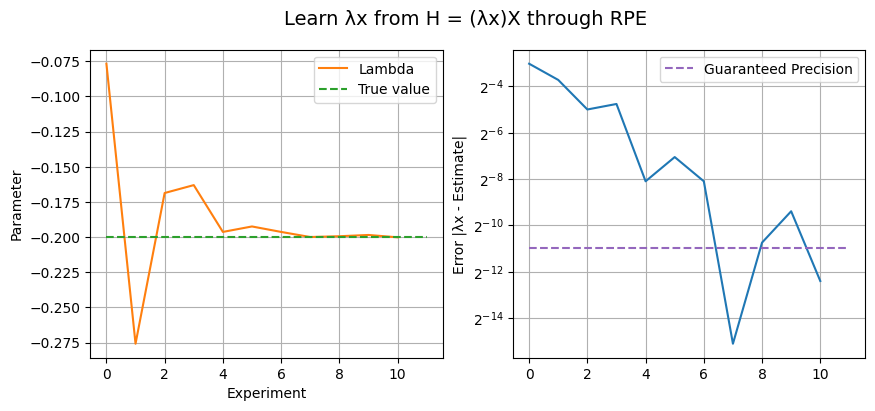

In [9]:
precision = 11
lambda_x, _ = RobustPhaseEstimation(precision, H_tilde, "X")
error = np.abs((lambda_x - px))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(lambda_x, label="Lambda", color="C1")
ax[0].set_xlabel("Experiment")
ax[0].set_ylabel("Parameter")
ax[0].hlines(px, xmin=0, xmax=precision, label="True value", linestyle="--", color="C2")
ax[0].grid()
ax[0].legend()

ax[1].plot(error)
ax[1].hlines(1/2**(11), xmin=0, xmax=precision, label="Guaranteed Precision", linestyle="--", color="C4")
ax[1].set_yscale('log', base=2)
ax[1].set_ylabel("Error |λx - Estimate|")
ax[1].grid()
ax[1].legend()

fig.suptitle("Learn λx from H = (λx)X through RPE", fontsize=14)
plt.show()

Now we can define a general function which takes in any single-qubit Hamiltonian and outputs its parameters. 

In [10]:
def learn_singleQHamiltonian(H, bitsPrecision, spam=0.0):
    estParams = np.array([0., 0., 0.])
    Paulis = ["X", "Y", "Z"]
    
    for i in range(3):
        if Paulis[i] == "X": 
            P = qt.sigmax()
        elif Paulis[i] == "Y":
            P = qt.sigmay()
        elif Paulis[i] == "Z": 
            P = qt.sigmaz()
            
        H_reshaped = 0.5 * H + 0.5 * P * H * P
        params, evolutionTime = RobustPhaseEstimation(bitsPrecision, H_reshaped, Paulis[i], spam=spam)
        estParams[i] = params[-1]
        
    print(f"The learned parameters are: px={estParams[0] :.3f}, py={estParams[1]:.3f}, pz={estParams[2]:.3f}")
    return estParams, evolutionTime

In [13]:
px, py, pz = [0.2, 0.5, 0.6]
H = px * qt.sigmax() + py * qt.sigmay() + pz * qt.sigmaz()
learned_params, time = learn_singleQHamiltonian(H, bitsPrecision=10)

The learned parameters are: px=0.199, py=0.499, pz=0.600


### Numerical Experiments

In [14]:
np.random.seed(3)
px, py, pz = np.random.rand(3)
H = px*qt.sigmax() + py*qt.sigmay() + pz*qt.sigmaz()
p_est, tot_time = learn_singleQHamiltonian(H, bitsPrecision=9)

print("      Actual     Estimate     Abs. Error (Bits)")
print(f"λx:   {px : .3f}     {p_est[0] : .3f}          {math.log(np.abs(px-p_est[0]), 2) : .0f}")
print(f"λy:   {py : .3f}     {p_est[1] : .3f}          {math.log(np.abs(py-p_est[1]), 2) : .0f}")  
print(f"λz:   {pz : .3f}     {p_est[2] : .3f}          {math.log(np.abs(pz-p_est[2]), 2) : .0f}")  

The learned parameters are: px=0.550, py=0.707, pz=0.291
      Actual     Estimate     Abs. Error (Bits)
λx:    0.551      0.550          -11
λy:    0.708      0.707          -10
λz:    0.291      0.291          -11


**Total Evolution Time**

In [24]:
experiments = np.arange(1, 11, 1)
precision = np.power(2, -1.*experiments)
precision_range = np.power(2, -1. * np.linspace(1, 10, 100))
tot_times = np.zeros_like(precision)

for i, p in enumerate(experiments): 
    p_est, tot_time = learn_singleQHamiltonian(H, bitsPrecision=p)
    tot_times[i] = tot_time

The learned parameters are: px=0.000, py=0.785, pz=0.464
The learned parameters are: px=0.554, py=0.554, pz=0.393
The learned parameters are: px=0.785, py=0.669, pz=0.277
The learned parameters are: px=0.589, py=0.727, pz=0.254
The learned parameters are: px=0.540, py=0.716, pz=0.324
The learned parameters are: px=0.540, py=0.712, pz=0.295
The learned parameters are: px=0.552, py=0.699, pz=0.295
The learned parameters are: px=0.549, py=0.708, pz=0.291
The learned parameters are: px=0.552, py=0.707, pz=0.291
The learned parameters are: px=0.552, py=0.708, pz=0.290


Compare different fits for $\mathcal{O}(\epsilon^{-1})$ versus $\mathcal{O}(\epsilon^{-2})$

In [25]:
def SQL_func(x, a, b):
    return a/x**2 + b

def HLS_func(x, a, b):
    return a/x + b

In [26]:
sql_popt, sql_pcov = scipy.optimize.curve_fit(SQL_func, precision, tot_times)
hls_popt, hls_pcov = scipy.optimize.curve_fit(HLS_func, precision, tot_times)

In [27]:
sql_perr = np.sqrt(np.diag(sql_pcov))
hls_perr = np.sqrt(np.diag(hls_pcov))

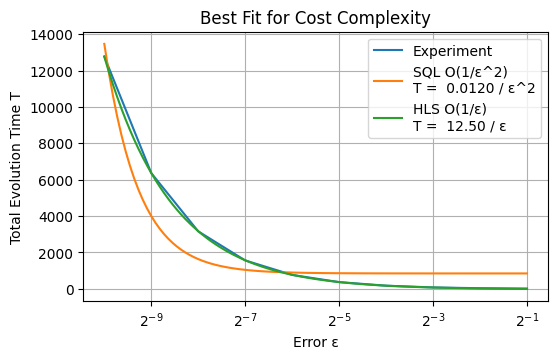

In [29]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.set_xscale('log', base=2)
# ax.set_yscale('log')
ax.plot(precision, tot_times, label="Experiment")
ax.plot(precision_range, SQL_func(precision_range, sql_popt[0], sql_popt[1]), label=f"SQL O(1/ε^2)\nT = {sql_popt[0] : .4f} / ε^2")
ax.plot(precision_range, HLS_func(precision_range, hls_popt[0], hls_popt[1]), label=f"HLS O(1/ε)\nT = {hls_popt[0] : .2f} / ε")
ax.legend()
ax.set_xlabel("Error ε")
ax.set_ylabel("Total Evolution Time T")
ax.set_title("Best Fit for Cost Complexity")
ax.grid()
plt.show()

### SPAM (Additive) Error

Suppose we know introduce state preparation and measurement (SPAM) error which introduces an additive constant to each of the $\ket{0}$- and $\ket{+}$-probabilities. Kimmel et al. states that such errors can be tolerated as long as they are bounded by $1/\sqrt{8}$. We test this hypothesis in the following experiment. 

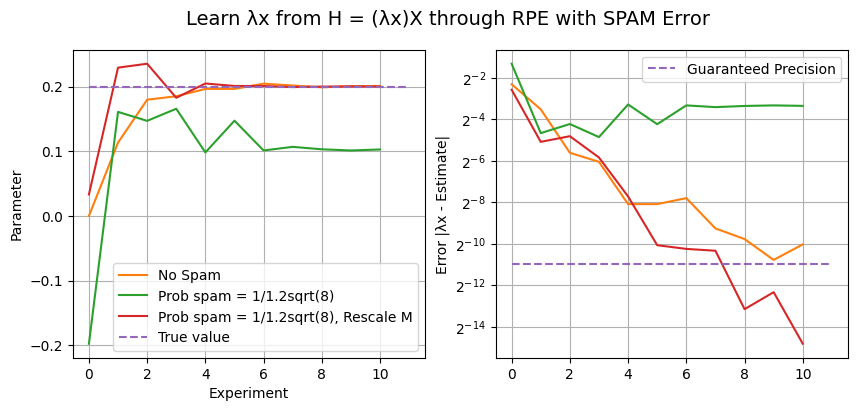

In [30]:
px, py, pz = [0.2, 0.5, 0.6]
H = px * qt.sigmax() + py * qt.sigmay() + pz * qt.sigmaz()
precision = 11

H_reshaped = 0.5 * H + 0.5 * qt.sigmax() * H * qt.sigmax()
lambda_nospam, _ = RobustPhaseEstimation(precision, H_reshaped, "X", spam=0.0)
lambda_spam, _ = RobustPhaseEstimation(precision, H_reshaped, "X", spam=1/(1.2*np.sqrt(8)))
lambda_limit, _ = RobustPhaseEstimation(precision, H_reshaped, "X", spam=1/(1.2*np.sqrt(8)), increaseM=True)

error_nospam = np.abs((lambda_nospam - px))
error_spam = np.abs((lambda_spam - px))
error_limit = np.abs((lambda_limit - px))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(lambda_nospam, label="No Spam", color="C1")
ax[0].plot(lambda_spam, label="Prob spam = 1/1.2sqrt(8)", color="C2")
ax[0].plot(lambda_limit, label="Prob spam = 1/1.2sqrt(8), Rescale M", color="C3")
ax[0].set_xlabel("Experiment")
ax[0].set_ylabel("Parameter")
ax[0].hlines(px, xmin=0, xmax=precision, label="True value", linestyle="--", color="C4")
ax[0].grid()
ax[0].legend()

ax[1].plot(error_nospam, color="C1")
ax[1].plot(error_spam, color="C2")
ax[1].plot(error_limit, color="C3")
ax[1].hlines(1/2**(11), xmin=0, xmax=precision, label="Guaranteed Precision", linestyle="--", color="C4")
ax[1].set_yscale('log', base=2)
ax[1].set_ylabel("Error |λx - Estimate|")
ax[1].grid()
ax[1].legend()

fig.suptitle("Learn λx from H = (λx)X through RPE with SPAM Error", fontsize=14)
plt.show()

**Probability of Error**

In [33]:
confidence_interval = 0.8
bound_err_max = 5e-2
precision = 10
px, py, pz = [0.2, 0.5, 0.6]
H = px * qt.sigmax() + py * qt.sigmay() + pz * qt.sigmaz()
H_reshaped = 0.5 * H + 0.5 * qt.sigmax() * H * qt.sigmax()

num_runs = int(np.log(2/((1-confidence_interval)/2)) / (2 * bound_err_max**2))
print(f"Number of Runs: {num_runs}")

Number of Runs: 599


In [34]:
nospam_failure = np.zeros(precision)
spam_failure = np.zeros(precision)
rescaleM_failure = np.zeros(precision)

In [35]:
for run in range(num_runs):
    if run % 20 == 0:
        print(f"Run {run} completed")
    lambda_nospam, _ = RobustPhaseEstimation(precision, H_reshaped, "X", spam=0.0)
    lambda_spam, _ = RobustPhaseEstimation(precision, H_reshaped, "X", spam=1/(2*np.sqrt(8)))
    lambda_rescaleM, _ = RobustPhaseEstimation(precision, H_reshaped, "X", spam=1/(2*np.sqrt(8)), increaseM=True)

    nospam_failure += (np.abs(lambda_nospam - px) > np.pi / np.power(2, np.arange(1, precision+1)))
    spam_failure += (np.abs(lambda_spam - px) > np.pi / np.power(2, np.arange(1, precision+1)))
    rescaleM_failure += (np.abs(lambda_rescaleM - px) > np.pi / np.power(2, np.arange(1, precision+1)))

Run 0 completed
Run 20 completed
Run 40 completed
Run 60 completed
Run 80 completed
Run 100 completed
Run 120 completed
Run 140 completed
Run 160 completed
Run 180 completed
Run 200 completed
Run 220 completed
Run 240 completed
Run 260 completed
Run 280 completed
Run 300 completed
Run 320 completed
Run 340 completed
Run 360 completed
Run 380 completed
Run 400 completed
Run 420 completed
Run 440 completed
Run 460 completed
Run 480 completed
Run 500 completed
Run 520 completed
Run 540 completed
Run 560 completed
Run 580 completed


In [36]:
nospam_failure /= num_runs
spam_failure /= num_runs
rescaleM_failure /= num_runs

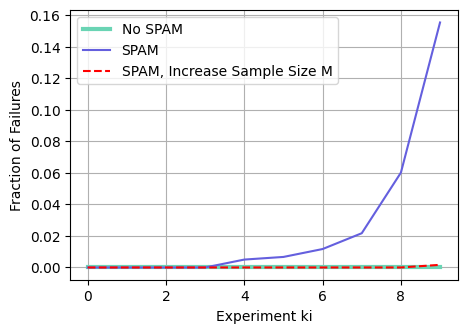

In [39]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(nospam_failure, label="No SPAM",linewidth=3.0, color="#6ad4b4")
ax.plot(spam_failure, label="SPAM", color="#645fde")
ax.plot(rescaleM_failure, label="SPAM, Increase Sample Size M", linestyle="--", color="red")
ax.set_xlabel("Experiment ki")
ax.set_ylabel("Fraction of Failures")  # for 600 Runs
ax.grid()
ax.legend()
plt.show()